# **Using the Random Forest Algorithm to Predict Earthquake Data**

## Imports 

Upload a kaggle.json authentification file to be able to load the dataset from kaggle. 

In [1]:
# make a directory to hold the authentification file 
!mkdir ~/.kaggle

# move the auth file to the dir
!mv kaggle.json ~/.kaggle/

# change the auth file permissions so that we can use it 
!chmod 600 /root/.kaggle/kaggle.json

**Import the dataset**

This dataset was posted on Kaggle via the US Geological Survey [here](https://www.kaggle.com/usgs/earthquake-database). 

> *Context*
>
> "The National Earthquake Information Center (NEIC) determines the location and size of all significant earthquakes that occur worldwide and disseminates this information immediately to national and international agencies, scientists, critical facilities, and the general public. The NEIC compiles and provides to scientists and to the public an extensive seismic database that serves as a foundation for scientific research through the operation of modern digital national and global seismograph networks and cooperative international agreements. The NEIC is the national data center and archive for earthquake information."

> *Content*
> 
> "This dataset includes a record of the date, time, location, depth, magnitude, and source of every earthquake with a reported magnitude 5.5 or higher since 1965."

In [2]:
!kaggle datasets download -d usgs/earthquake-database --force
!unzip earthquake-database.zip

  0% 0.00/590k [00:00<?, ?B/s]
100% 590k/590k [00:00<00:00, 77.4MB/s]
Archive:  earthquake-database.zip
  inflating: database.csv            


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import re 
import datetime
import time

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [4]:
# set path variables to the data 
dataset_path = '/content/database.csv'

## Understanding & preprocessing the data

In [5]:
# read data into a pandas dataframe to make it easier to work with 
data = pd.read_csv(dataset_path)

In [6]:
# get a first look at the data 
display(data)

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,0.320,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,0.260,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,NaN,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,NaN,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed


It's easy to see that we have both columns with lots of NaN values and some columns e.g. ID or Status, that will not be helpful in making predictions. 

So, we should remove these columns. 

In [7]:
# remove columns that have more than 50% NaN values 
data.dropna(thresh=(len(data)*.5), axis=1, inplace=True)
display(data)

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,6.0,MW,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,5.8,MW,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,6.2,MW,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,5.8,MW,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,5.8,MW,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,5.6,ML,0.1898,NN00570710,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,5.5,ML,0.2187,NN00570744,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,5.9,MWW,1.5200,US10007NAF,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,6.3,MWW,1.4300,US10007NL0,US,US,US,Reviewed


You can see that this has already removed 7 columns. 

In [8]:
# remove all columns including and after RMS 
data.drop(data.iloc[:, 7:], inplace=True, axis=1) 

display(data)

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,6.0
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,5.8
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,6.2
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,5.8
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,5.8
...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,5.6
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,5.5
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,5.9
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,6.3


It's important to note that not all of the events are earthquakes. 

In [9]:
# see the break down of different magnitude types 
data['Type'].value_counts()

Earthquake           23232
Nuclear Explosion      175
Explosion                4
Rock Burst               1
Name: Type, dtype: int64

In [10]:
# remove rows that are not earthquakes 
data.drop(data.loc[data['Type']!='Earthquake'].index, inplace=True)

data['Type'].value_counts()

Earthquake    23232
Name: Type, dtype: int64

Now we can remove the "Type" column from our data, because it is redundant. 

In [11]:
del data['Type']

display(data)

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.2460,145.6160,131.60,6.0
1,01/04/1965,11:29:49,1.8630,127.3520,80.00,5.8
2,01/05/1965,18:05:58,-20.5790,-173.9720,20.00,6.2
3,01/08/1965,18:49:43,-59.0760,-23.5570,15.00,5.8
4,01/09/1965,13:32:50,11.9380,126.4270,15.00,5.8
...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,12.30,5.6
23408,12/28/2016,09:13:47,38.3777,-118.8957,8.80,5.5
23409,12/28/2016,12:38:51,36.9179,140.4262,10.00,5.9
23410,12/29/2016,22:30:19,-9.0283,118.6639,79.00,6.3


Now we want to convert the "Date" and "Time" data that the model will be able to make sense of.

In [12]:
# creates a new column of values with a timestamp created from the combination fo date and time 
timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')
        
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values

In [13]:
# drop the date and time columns because they aren't of any use anymore 
data = data.drop(['Date', 'Time'], axis=1)

# remove rows where there was an error coverting to a timestamp 
data = data[data.Timestamp != 'ValueError']

# check out the finalized data 
display(data)

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.2460,145.6160,131.60,6.0,-1.57631e+08
1,1.8630,127.3520,80.00,5.8,-1.57466e+08
2,-20.5790,-173.9720,20.00,6.2,-1.57356e+08
3,-59.0760,-23.5570,15.00,5.8,-1.57094e+08
4,11.9380,126.4270,15.00,5.8,-1.57026e+08
...,...,...,...,...,...
23407,38.3917,-118.8941,12.30,5.6,1.48291e+09
23408,38.3777,-118.8957,8.80,5.5,1.48292e+09
23409,36.9179,140.4262,10.00,5.9,1.48293e+09
23410,-9.0283,118.6639,79.00,6.3,1.48305e+09


## Analyzing Data

Taking a closer look at depth and magnitude, the labels we want to predict. 

In [14]:
# define a custom round function so we can round values to the nearest "base" magnitude 
def custom_round(x, base):
    return base * round(float(x)/base)

In [15]:
# checking out the spread of magnitude across data points 
rounded_mag = data['Magnitude'].apply(lambda x: custom_round(x, base=0.25)) # round mag. values to nearest 0.25
mag_spread = rounded_mag.value_counts() # check out the spread of data 
print(mag_spread)

5.50    8610
5.75    5404
6.00    4673
6.25    1670
6.50    1401
6.75     547
7.00     477
7.25     165
7.50     151
7.75      70
8.00      41
8.25      12
8.50       4
9.00       2
8.75       2
Name: Magnitude, dtype: int64


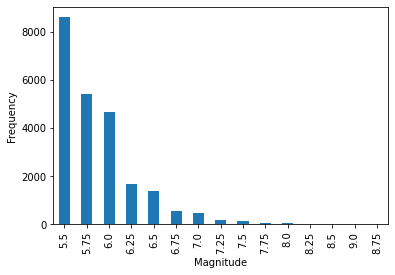

In [16]:
mag_spread.plot(xlabel='Magnitude', ylabel='Frequency', kind='bar')

In [17]:
# checking out the spread of depth across data points 
rounded_depth = data['Depth'].round(decimals=-1) # round depth values to nearest 10
depth_spread = rounded_depth.value_counts() # check out the spread of data 
print(depth_spread)

30.0     5721
10.0     5518
20.0     2743
40.0     2200
50.0     1042
         ... 
300.0       8
680.0       7
670.0       6
690.0       4
700.0       1
Name: Depth, Length: 71, dtype: int64


In [18]:
data['Magnitude'] = rounded_mag
data['Depth'] = rounded_depth
display(data)

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.2460,145.6160,130.0,6.00,-1.57631e+08
1,1.8630,127.3520,80.0,5.75,-1.57466e+08
2,-20.5790,-173.9720,20.0,6.25,-1.57356e+08
3,-59.0760,-23.5570,20.0,5.75,-1.57094e+08
4,11.9380,126.4270,20.0,5.75,-1.57026e+08
...,...,...,...,...,...
23407,38.3917,-118.8941,10.0,5.50,1.48291e+09
23408,38.3777,-118.8957,10.0,5.50,1.48292e+09
23409,36.9179,140.4262,10.0,6.00,1.48293e+09
23410,-9.0283,118.6639,80.0,6.25,1.48305e+09


## Split into train and test data

In [19]:
# get the first three columns, which are the feature attributes that we want to train the model on 
features = data[['Timestamp', 'Latitude', 'Longitude', 'Magnitude']]
labels = data[['Depth']]

#split the data into test & train 
train, test, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state=5)

In [20]:
print('Training Features Shape:', train.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (17421, 4)
Training Labels Shape: (17421, 1)
Testing Features Shape: (5808, 4)
Testing Labels Shape: (5808, 1)


## Build the random forest classifier. 

In [21]:
# build the model with 100 trees
model = RandomForestRegressor(n_estimators=100,
                               criterion='mse',
                               n_jobs=-1, 
                               verbose=1)

# fit the model on training data
model.fit(train, train_labels)
test_pred = model.predict(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


## Analyze model results 

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, test_pred)))
print('R2 Score:', metrics.r2_score(test_labels, test_pred))

Mean Absolute Error: 20.11642561983471
Mean Squared Error: 1910.1117320936642
Root Mean Squared Error: 43.704825043622634
R2 Score: 0.8651527852228991


Look at the feature importance for each of the features, aka the columns. 

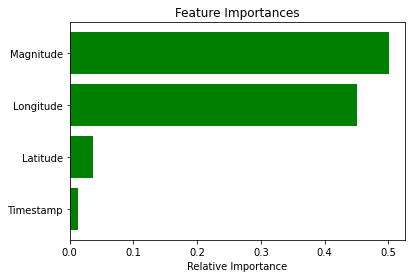

In [23]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.show()